<a href="https://colab.research.google.com/github/Tanish-Sarkar/Elite-Transformers/blob/main/Module2%20-%20Attention%20Deep%20Dive/multihead_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

## Re-constructing our single-head class

In [2]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, Q, K, V, mask=None):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2,-1)) / math.sqrt(d_k)

    if mask is not None:
      scores = scores.masked_fill(mask == 0, float('-inf'))

    attn = F.softmax(scores, dim=1)
    return torch.matmul(attn, V), attn

## Mutli head Attention

In [11]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super().__init__()
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

    self.d_model = d_model # Added this line
    self.num_heads = num_heads
    self.d_head = d_model // num_heads

    # Linear Projections for Q, K, V (all in one go)
    self.W_q = nn.Linear(d_model, d_model)
    self.W_k = nn.Linear(d_model, d_model)
    self.W_v = nn.Linear(d_model, d_model)

    # Final linear projection
    self.W_o = nn.Linear(d_model, d_model)

    self.attention = ScaledDotProductAttention()

  def forward(self, x, mask=None):
    B, T, C = x.shape

    # 1. Project input to Q, K, V
    Q = self.W_q(x)
    K = self.W_k(x)
    V = self.W_v(x)

    # 2. split into multiple heads
    # Reshape: (B, T, num_heads, d_head) → (B, num_heads, T, d_head)
    Q = Q.view(B, T, self.num_heads, self.d_head).transpose(1,2)
    K = K.view(B, T, self.num_heads, self.d_head).transpose(1,2)
    V = V.view(B, T, self.num_heads, self.d_head).transpose(1,2)

    # 3. Apply attention to all heads in parallel
    #    Q,K,V now: (B, H, T, d_head)
    head_outputs, head_weights = self.attention(Q,K,V, mask)

    # 4. Concatenate heads back together
    #    (B, H, T, d_head) → (B, T, H, d_head) → (B, T, C)
    head_outputs = head_outputs.transpose(1, 2).contiguous()
    head_outputs = head_outputs.view(B,T,C)

    # 5. Final linear projection
    out = self.W_o(head_outputs)

    return out, head_weights



## **Smaple Testing**

In [12]:
d_model, num_heads, B, T = 64, 8, 2, 10
x = torch.randn(B, T, d_model)

mha = MultiHeadAttention(d_model, num_heads)
output , all_head_weights = mha(x)

print("Input shape:     ", x.shape)
print("Output shape:    ", output.shape)
print("Head weights shape:", all_head_weights.shape)   # (B, H, T, T)

Input shape:      torch.Size([2, 10, 64])
Output shape:     torch.Size([2, 10, 64])
Head weights shape: torch.Size([2, 8, 10, 10])


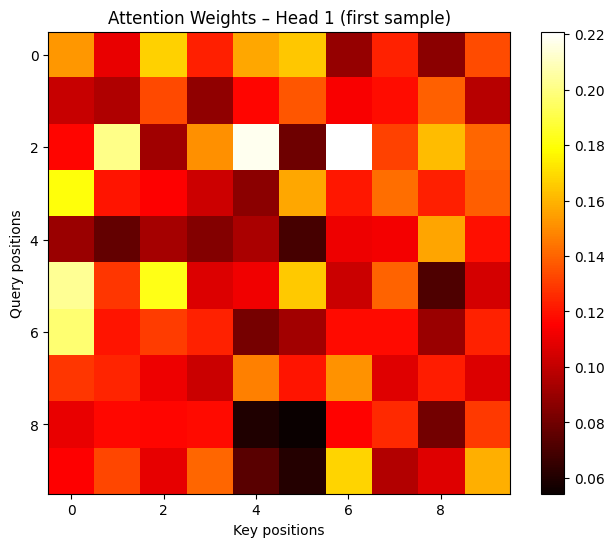

In [13]:
import matplotlib.pyplot as plt

# Look at first batch, first head
plt.figure(figsize=(8, 6))
plt.imshow(all_head_weights[0, 0].detach().numpy(), cmap='hot', interpolation='nearest')
plt.title("Attention Weights – Head 1 (first sample)")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.colorbar()
plt.show()